# **The Virtual Judge Experiment - An Incarceration Analysis of Texas**


*   Can we predict an individuals sentencing based on all factors?
*   What factors give the most weight to the decision? Can we be more fair than a real judge?
*   Can we predict if an inmate to be approved for parole?




## **Importing Data**



Importing Dependencies

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from google.colab import drive
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix
from catboost.utils import get_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel('./Data/Texas_Inmates.xlsx')  
df.head()

,TDCJ Number,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,Case Number,County,Offense Code,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
SID Number,,,,,,,,,,,,,,,,,,,
524524,758486,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,95-765-C,McLennan,11180000,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,Life,None,08/03/2026,NOT IN REVIEW PROCESS
703267,841623,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,97-396-C,McLennan,11990003,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS
770626,449674,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,86CR-1234-B,Nueces,9150000,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,Life,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS
771601,1491019,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,1144294,Harris,12990002,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS
779423,1241039,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,"04CR-16,149",Shelby,11990003,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS


## **Data Cleaning**

In [4]:
 df.shape

(117697, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117697 entries, 524524 to 96414913
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   TDCJ Number              117697 non-null  int64 
 1   Name                     117697 non-null  object
 2   Current Facility         117697 non-null  object
 3   Gender                   117697 non-null  object
 4   Race                     117697 non-null  object
 5   Age                      117697 non-null  int64 
 6   Projected Release        117697 non-null  object
 7   Maximum Sentence Date    117697 non-null  object
 8   Parole Eligibility Date  117697 non-null  object
 9   Case Number              117620 non-null  object
 10  County                   117697 non-null  object
 11  Offense Code             117697 non-null  int64 
 12  TDCJ Offense             117697 non-null  object
 13  Sentence Date            117697 non-null  object
 14  Offense Date 

### Dropping Unnecessary Columns

In [6]:
df['TDCJ Number'].unique
df['Offense Code'].unique
df['Case Number'].unique

<bound method Series.unique of SID Number
524524          95-765-C
703267          97-396-C
770626       86CR-1234-B
771601           1144294
779423       04CR-16,149
                ...     
50824270          21198B
50824296     241-0316-16
50824431         CR02467
50824569    CR-1090-19-D
96414913        86256-CR
Name: Case Number, Length: 117697, dtype: object>

In [7]:
df_clean = df.drop(columns=['TDCJ Number','Case Number','Offense Code'])

### **Looking at missing values in columns**

In [8]:
null_data = df[df.isnull().any(axis=1)]

### **New data frame with only non-life sentences (df_nolife)**

In [9]:
df_nolife = df_clean.loc[(df_clean['Sentence (Years)'] != 'Life') & (df_clean['Sentence (Years)'] != 'Capital Life') & (df_clean['Sentence (Years)'] != 'Death') & (df_clean['Sentence (Years)'] != 'LWOP'),:]

In [10]:
df_nolife['Sentence (Years)'] = df_nolife['Sentence (Years)'].astype(float, errors = 'raise')
df_nolife = df_nolife[df_nolife['Sentence (Years)'] < 2000]
df_nolife.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
SID Number,,,,,,,,,,,,,,,,
703267,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS
771601,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS
834039,"GARCIA,BASILIO ELIGIO",Hospital Galveston,M,H,82,2023-04-15 00:00:00,2023-04-15 00:00:00,2005-06-15 00:00:00,Tom Green,FAIL REG AS SEX OFFENDER,2003-08-15 00:00:00,2003-04-08 00:00:00,20.0,Denied on 03/10/2020,NaN,NOT IN REVIEW PROCESS
851645,"DAVIS,GLIDDON WILLIAM",Beto,M,W,83,2066-07-14 00:00:00,2066-07-14 00:00:00,2039-01-13 00:00:00,Montgomery,DWI 3RD/M,2011-07-20 00:00:00,2009-09-01 00:00:00,55.0,None,01/13/2039,NOT IN REVIEW PROCESS


### **New data frame with only life sentences (df_life)**

In [11]:
df_life = df_clean.loc[(df_clean['Sentence (Years)'] == 'Life') | (df_clean['Sentence (Years)'] == 'Capital Life') | (df_clean['Sentence (Years)'] == 'Death') 
             | (df_clean['Sentence (Years)'] == 'LWOP')]
df_life.head()

,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
SID Number,,,,,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,Life,None,08/03/2026,NOT IN REVIEW PROCESS
770626,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,Life,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS
799447,"DOWDEN,BILLY WAYNE",Stiles,M,W,84,9999-01-01 00:00:00,9999-01-01 00:00:00,1981-05-24 00:00:00,Harris,CAPITAL MURDER,1975-04-30 00:00:00,1974-06-28 00:00:00,Capital Life,Denied on 10/25/2016,Unavailable at this time.,IN PAROLE REVIEW PROCESS
801785,"CRAWFORD,WILLIE RAY",Pack,M,B,83,9999-01-01 00:00:00,9999-01-01 00:00:00,2033-03-12 00:00:00,Dallas,SEXUAL ASLT,2003-09-24 00:00:00,2002-09-14 00:00:00,Life,None,03/12/2033,NOT IN REVIEW PROCESS
865745,"VILLARREAL,JESSE",Allred,M,H,80,9999-01-01 00:00:00,9999-01-01 00:00:00,1982-05-22 00:00:00,Harris,CAPITAL MURDER,1975-10-06 00:00:00,1975-03-24 00:00:00,Capital Life,Denied on 06/16/2021,06/2026,NOT IN REVIEW PROCESS


### Changing Life and years that are greater than 100 to be 100

In [12]:
def convertSentenceYears(x):
  if x == 'Life' or x == 'Capital Life' or x == 'Death' or x == 'LWOP':
    return 100.0
  else:
    if float(x) > 100:
      return 100
    else:
      return float(x)

df_clean["Sentence (Years)"] = df_clean["Sentence (Years)"].map(lambda x: convertSentenceYears(x), na_action='ignore')
df_clean.head()

,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status
SID Number,,,,,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,None,08/03/2026,NOT IN REVIEW PROCESS
703267,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS
770626,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS
771601,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS


In [13]:
df_clean.describe()

,Age,Sentence (Years)
count,117697.000000,117697.000000
mean,40.881042,24.948723
std,12.461478,28.314456
min,16.000000,0.100000
25%,31.000000,6.000000
50%,39.000000,14.000000
75%,50.000000,30.000000
max,93.000000,100.000000


## **Getting To Know The Data**

Text(0.5, 0, 'Age')

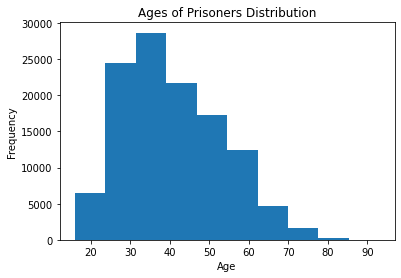

In [14]:
Age_df = df["Age"].dropna()
Age_df.plot.hist()
plt.title("Ages of Prisoners Distribution")
plt.xlabel("Age")

In [15]:
sum(Age_df.between(30,50))/len(df)*100

56.852766000832645

Most of the prisoners incarcerated are in their 30-40's as together they make up 56.82% of the prison population.

Text(0.5, 1.0, 'Genders of Prisoners Distribution')

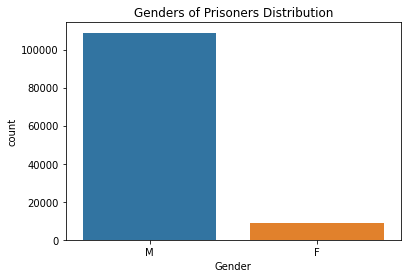

In [16]:
sns.countplot(x = "Gender", data = df)
plt.title("Genders of Prisoners Distribution")

In [17]:
Gender_df = df["Gender"]
Gender_df = Gender_df.map({'M' :1, 'F' :0})
sum(Gender_df)/len(Gender_df)*100

92.47559411030018

There is an overwhelming gender inequality in prison with 92.47% of the prison population being male.

Text(0.5, 1.0, 'Race of Prisoners Distribution')

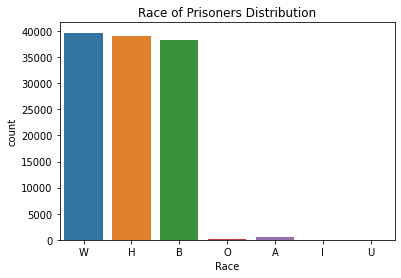

In [18]:
sns.countplot(x = "Race", data = df)
plt.title("Race of Prisoners Distribution")

In [19]:
(df_nolife['Sentence (Years)'] == 'LWOP')

SID Number
703267      False
771601      False
779423      False
834039      False
851645      False
            ...  
50824270    False
50824296    False
50824431    False
50824569    False
96414913    False
Name: Sentence (Years), Length: 108329, dtype: bool

In [20]:
nolife_df = df_nolife["Sentence (Years)"].dropna()
nolife_df.describe()

count    108329.000000
mean         18.492545
std          18.825849
min           0.100000
25%           6.000000
50%          12.000000
75%          25.000000
max         800.000000
Name: Sentence (Years), dtype: float64

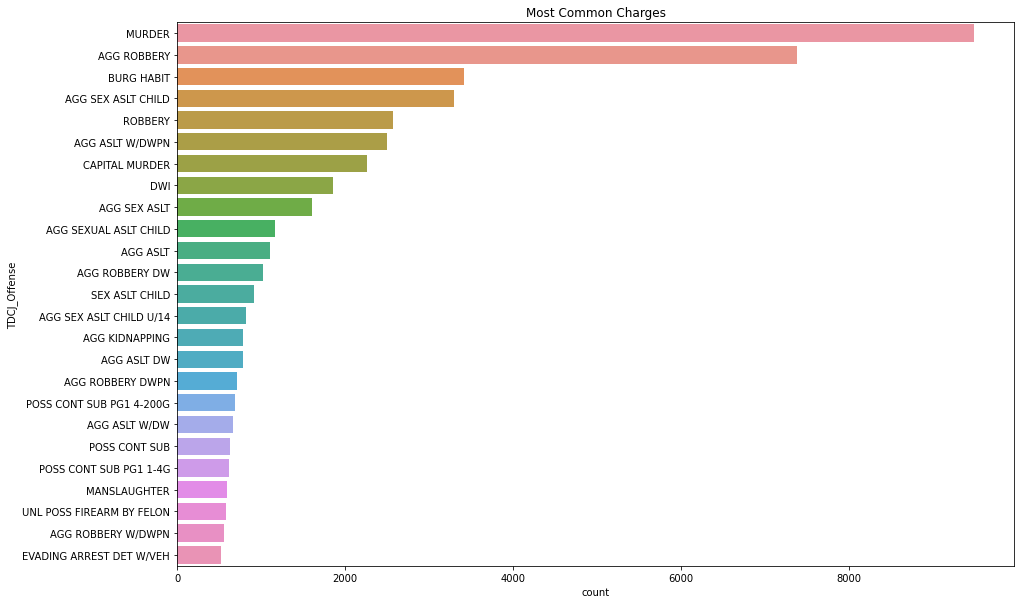

In [21]:
df_clean["TDCJ_Offense"] = df_clean["TDCJ Offense"]
plt.figure(figsize=(15,10))
ax = sns.countplot(y=df_clean.TDCJ_Offense, order=df_clean.TDCJ_Offense.value_counts().iloc[:25].index
                  ).set_title("Most Common Charges")

In [22]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

crime_stats = df_clean['Sentence (Years)'].groupby(df_clean['TDCJ Offense']).apply(get_stats).unstack()
crime_stats = crime_stats.sort_values(by='count', ascending=False)
crime_stats.head(20)

,min,max,count,mean
TDCJ Offense,,,,
MURDER,5.0,100.0,9496.0,53.351201
AGG ROBBERY,2.0,100.0,7381.0,27.735740
BURG HABIT,2.0,100.0,3415.0,16.096105
AGG SEX ASLT CHILD,4.0,100.0,3300.0,34.579697
ROBBERY,0.3,100.0,2577.0,14.741133
AGG ASLT W/DWPN,2.0,100.0,2498.0,10.165612
CAPITAL MURDER,10.0,100.0,2268.0,98.963845
DWI,2.0,100.0,1855.0,14.109434
AGG SEX ASLT,5.0,100.0,1605.0,50.370156


## **Feature Engineering**

### Encoding sentence years to Offense Score

In [23]:
offenseDict = {"MURDER": 200, "ROBBERY": 50, "POSS": 50, "SEX": 100, "SEXUAL": 100, "ASSAULT": 100, "ALST": 100, "CHILD": 100, "<1G": 50, "DWI": 50, "AGG": 100}
def assignOffenseScore(x):
  score = 0
  words = x.split()
  for i in words:
    if i in offenseDict.keys():
      score += offenseDict[i]
  return score

df_clean["Offense Score"] = df_clean["TDCJ Offense"].map(lambda x: assignOffenseScore(x), na_action='ignore')
df_clean.head()

,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,TDCJ_Offense,Offense Score
SID Number,,,,,,,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,None,08/03/2026,NOT IN REVIEW PROCESS,AGG SEXUAL ASSAULT,300
703267,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS,AGG SEX ASLT,200
770626,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS,MURDER W/DEADLY WPN,200
771601,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS,AGG ROBBERY W/DW,150
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS,AGG SEXUAL ALST,300


In [24]:
new_df = df_clean.groupby("County")["Sentence (Years)"].mean().reset_index()
new_df.sort_values(['Sentence (Years)'], ascending=False)
new_df.head(10)

,County,Sentence (Years)
0,Anderson,22.851220
1,Andrews,20.951220
2,Angelina,24.416244
3,Aransas,19.317073
4,Archer,28.600000
5,Armstrong,15.142857
6,Atascosa,22.125490
7,Austin,28.131707
8,Bailey,20.311111
9,Bandera,25.028090


### Encoding Last Parole Decision

In [25]:
df['Last Parole Decision'].unique

<bound method Series.unique of SID Number
524524                        None
703267      Approved on 08/18/2021
770626        Denied on 07/21/2021
771601                        None
779423        Denied on 10/30/2019
                     ...          
50824270    Approved on 09/15/2021
50824296                      None
50824431                      None
50824569      Denied on 10/27/2020
96414913                       NaN
Name: Last Parole Decision, Length: 117697, dtype: object>

Creating a new column with parole decision only (no date).

In [26]:
def getParoleDecision(x):
  decision = x.split()
  if decision[0] == "Approved":
    return 1
  else:
    return 0
  return decision[0]
print(getParoleDecision("Approved on 09/15/2021"))

1


In [27]:
df_clean["Parole_Decision"] = df_clean["Last Parole Decision"].map(lambda x: getParoleDecision(x), na_action='ignore')
df_clean.head()

,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,TDCJ_Offense,Offense Score,Parole_Decision
SID Number,,,,,,,,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,None,08/03/2026,NOT IN REVIEW PROCESS,AGG SEXUAL ASSAULT,300,0.0
703267,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS,AGG SEX ASLT,200,1.0
770626,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS,MURDER W/DEADLY WPN,200,0.0
771601,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS,AGG ROBBERY W/DW,150,0.0
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS,AGG SEXUAL ALST,300,0.0


In [28]:
df_clean["Parole_Decision"].value_counts()

0.0    96323
1.0    12266
Name: Parole_Decision, dtype: int64

### Calculating the age of the person when crime was committed (Removing any target leaking for future models)

In [29]:
def calcAgeCommited(age, year):
  prison_years = 2021 - year
  commited_age = age - prison_years
  return age


def getYearCommited(date):
  arr = (date.split("-"))
  return float(arr[0])
print(getYearCommited("1995-09-15 00:00:00"))

1995.0


In [30]:
df_clean["Offense Date"] = df_clean["Offense Date"].astype(str)
df_clean = df_clean.loc[df_clean["Offense Date"] != "#NULL!", :]

In [31]:
df_clean["Year_Commited"] = df_clean["Offense Date"].map(lambda x: getYearCommited(x), na_action='ignore')
df_clean.head()
df_clean["Age_Commited"] = df_clean["Age"] - (2021 - df_clean["Year_Commited"])

## **Modeling**

In [32]:
df_clean.head()

,Name,Current Facility,Gender,Race,Age,Projected Release,Maximum Sentence Date,Parole Eligibility Date,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Last Parole Decision,Next Parole Review Date,Parole Review Status,TDCJ_Offense,Offense Score,Parole_Decision,Year_Commited,Age_Commited
SID Number,,,,,,,,,,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,93,9999-01-01 00:00:00,9999-01-01 00:00:00,2026-08-03 00:00:00,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,None,08/03/2026,NOT IN REVIEW PROCESS,AGG SEXUAL ASSAULT,300,0.0,1995.0,67.0
703267,"RODRIGUEZ,THEODORE",Beto,M,W,83,2021-11-01 00:00:00,2043-08-03 00:00:00,2021-02-01 00:00:00,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,Approved on 08/18/2021,NaN,NOT IN REVIEW PROCESS,AGG SEX ASLT,200,1.0,1996.0,58.0
770626,"FLORES,ISABEL",Pack,M,H,84,9999-01-01 00:00:00,9999-01-01 00:00:00,2006-09-02 00:00:00,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,Denied on 07/21/2021,07/2024,NOT IN REVIEW PROCESS,MURDER W/DEADLY WPN,200,0.0,1986.0,49.0
771601,"MOLETT,JOHN HENRY",Pack,M,B,79,2037-12-02 00:00:00,2037-12-02 00:00:00,2022-12-02 00:00:00,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,None,12/02/2022,NOT IN REVIEW PROCESS,AGG ROBBERY W/DW,150,0.0,2007.0,65.0
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,84,2023-06-19 00:00:00,2023-06-19 00:00:00,2013-06-18 00:00:00,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,Denied on 10/30/2019,09/2022,NOT IN REVIEW PROCESS,AGG SEXUAL ALST,300,0.0,1999.0,62.0


In [33]:
df_clean["Year_Commited"].describe()

count    117696.000000
mean       2012.494435
std           8.038875
min        1960.000000
25%        2009.000000
50%        2015.000000
75%        2018.000000
max        2021.000000
Name: Year_Commited, dtype: float64

In [34]:
under_2012 = df_clean.loc[(df_clean["Year_Commited"] <= 2012) & (df_clean["Sentence (Years)"] == 100)]
under_2012.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8101 entries, 524524 to 50821443
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     8101 non-null   object 
 1   Current Facility         8101 non-null   object 
 2   Gender                   8101 non-null   object 
 3   Race                     8101 non-null   object 
 4   Age                      8101 non-null   int64  
 5   Projected Release        8101 non-null   object 
 6   Maximum Sentence Date    8101 non-null   object 
 7   Parole Eligibility Date  8101 non-null   object 
 8   County                   8101 non-null   object 
 9   TDCJ Offense             8101 non-null   object 
 10  Sentence Date            8101 non-null   object 
 11  Offense Date             8101 non-null   object 
 12  Sentence (Years)         8101 non-null   float64
 13  Last Parole Decision     7040 non-null   object 
 14  Next Parole Rev

In [35]:
over_2012 = df_clean.loc[(df_clean["Year_Commited"] >= 2012) & (df_clean["Sentence (Years)"] == 100)]
over_2012.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 1317111 to 50824265
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Name                     1649 non-null   object 
 1   Current Facility         1649 non-null   object 
 2   Gender                   1649 non-null   object 
 3   Race                     1649 non-null   object 
 4   Age                      1649 non-null   int64  
 5   Projected Release        1649 non-null   object 
 6   Maximum Sentence Date    1649 non-null   object 
 7   Parole Eligibility Date  1649 non-null   object 
 8   County                   1649 non-null   object 
 9   TDCJ Offense             1649 non-null   object 
 10  Sentence Date            1649 non-null   object 
 11  Offense Date             1649 non-null   object 
 12  Sentence (Years)         1649 non-null   float64
 13  Last Parole Decision     1061 non-null   object 
 14  Next Parole Re

## **CatBoost**

### Predicting Life In Prison

In [36]:
df_model=df_clean.drop(columns = ['Projected Release', 'Maximum Sentence Date', 'Parole Eligibility Date', 'Last Parole Decision', 'Next Parole Review Date', 'TDCJ_Offense', 'Current Facility', 'Age', 'Year_Commited', 'Parole_Decision', 'Parole Review Status'])
df_model.head()

,Name,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Age_Commited
SID Number,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,300,67.0
703267,"RODRIGUEZ,THEODORE",M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,200,58.0
770626,"FLORES,ISABEL",M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,200,49.0
771601,"MOLETT,JOHN HENRY",M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,150,65.0
779423,"CARAWAY,LEON JR",M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,300,62.0


In [37]:
def life(x):
  if x == 100:
      return 1
  else:
     return 0

df_model["Sentence (Years)"] = df_model["Sentence (Years)"].map(lambda x: life(x), na_action='ignore')
df_model["Offense Date"] = df_model["Offense Date"].astype(str)
df_model["Sentence Date"] = df_model["Sentence Date"].astype(str)

df_model = df_model.dropna()

df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117696 entries, 524524 to 96414913
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Name              117696 non-null  object 
 1   Gender            117696 non-null  object 
 2   Race              117696 non-null  object 
 3   County            117696 non-null  object 
 4   TDCJ Offense      117696 non-null  object 
 5   Sentence Date     117696 non-null  object 
 6   Offense Date      117696 non-null  object 
 7   Sentence (Years)  117696 non-null  int64  
 8   Offense Score     117696 non-null  int64  
 9   Age_Commited      117696 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 9.9+ MB


In [38]:
df_model['Sentence (Years)'].value_counts()

0    108257
1      9439
Name: Sentence (Years), dtype: int64

In [39]:
df_balance_model = df_model[df_model['Sentence (Years)'] == 0]
df_balance_model = df_balance_model.sample(n=9439)
df_balance_model.shape[0]

9439

In [40]:
train_miss = df_model[df_model['Sentence (Years)'] == 1]
df_balance_model = pd.concat([df_balance_model, train_miss])
df_balance_model['Sentence (Years)'].value_counts()

1    9439
0    9439
Name: Sentence (Years), dtype: int64

In [41]:
# With BALANCING
X = df_balance_model.drop(columns = ['Sentence (Years)'])
y = df_balance_model['Sentence (Years)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_balance_model.select_dtypes(include=np.object).columns.to_list()

In [42]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6652102	test: 0.6633070	best: 0.6633070 (0)	total: 58.6ms	remaining: 2.87s
1:	learn: 0.6373397	test: 0.6326085	best: 0.6326085 (1)	total: 67.6ms	remaining: 1.62s
2:	learn: 0.6126734	test: 0.6052729	best: 0.6052729 (2)	total: 75.3ms	remaining: 1.18s
3:	learn: 0.5916967	test: 0.5819659	best: 0.5819659 (3)	total: 80.4ms	remaining: 925ms
4:	learn: 0.5742553	test: 0.5615718	best: 0.5615718 (4)	total: 85.7ms	remaining: 771ms
5:	learn: 0.5588874	test: 0.5447027	best: 0.5447027 (5)	total: 90.9ms	remaining: 667ms
6:	learn: 0.5451010	test: 0.5295660	best: 0.5295660 (6)	total: 96.1ms	remaining: 590ms
7:	learn: 0.5351514	test: 0.5179687	best: 0.5179687 (7)	total: 101ms	remaining: 532ms
8:	learn: 0.5252158	test: 0.5068305	best: 0.5068305 (8)	total: 108ms	remaining: 494ms
9:	learn: 0.5177991	test: 0.4987554	best: 0.4987554 (9)	total: 119ms	remaining: 477ms
10:	learn: 0.5077108	test: 0.4861058	best: 0.4861058 (10)	total: 128ms	remaining: 455ms
11:	learn: 0.4996501	test: 0.4761804	best: 0.

In [43]:
model.score(X_test, y_test)

0.8195621468926554

In [44]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["Not Life", "Life"]))

              precision    recall  f1-score   support

    Not Life       0.82      0.82      0.82      2842
        Life       0.82      0.82      0.82      2822

    accuracy                           0.82      5664
   macro avg       0.82      0.82      0.82      5664
weighted avg       0.82      0.82      0.82      5664



In [45]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

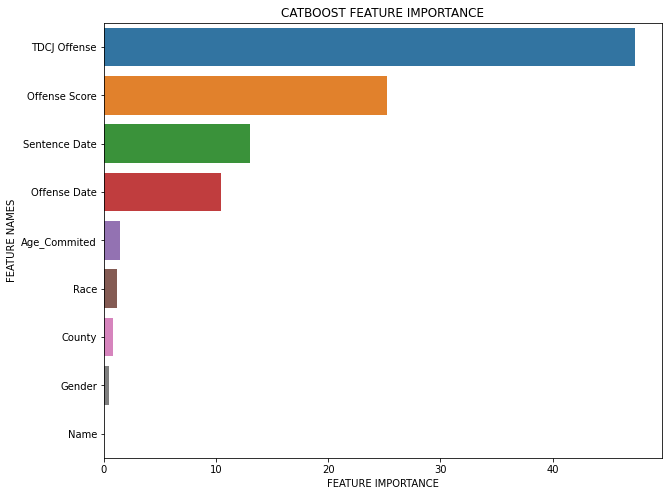

In [46]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

In [47]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[5865.  732.]
 [ 771. 5846.]]


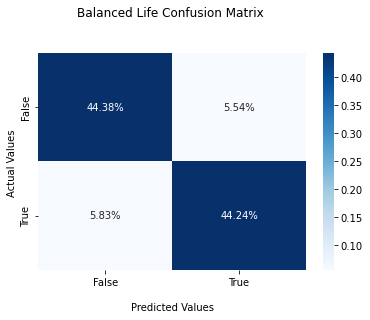

In [48]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Balanced Life Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

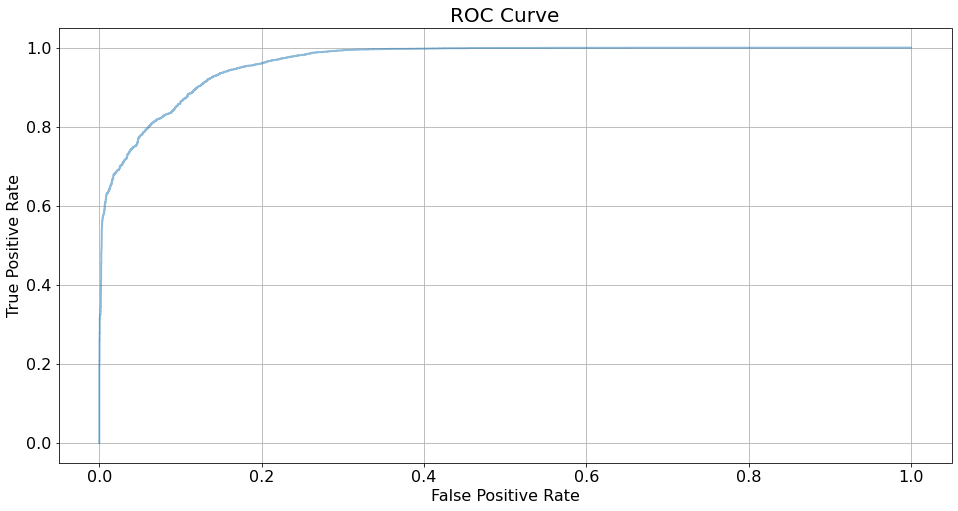

In [49]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

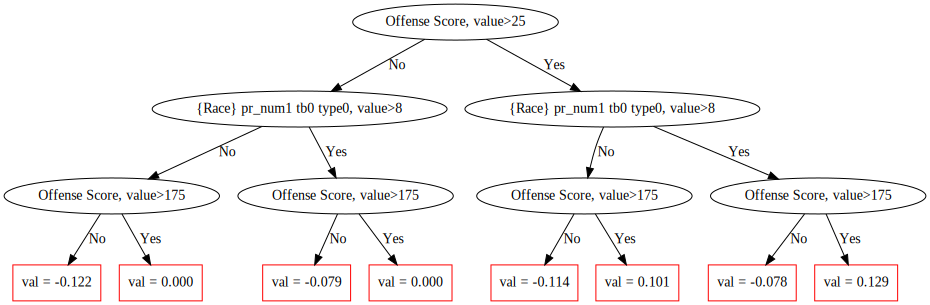

In [50]:
model.plot_tree(
    tree_idx=0,
    pool=Pool(X_train, y_train, cat_features=categorical_features)
)

In [51]:
# Without BALANCING
X = df_model.drop(columns = ['Sentence (Years)'])
y = df_model['Sentence (Years)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_model.select_dtypes(include=np.object).columns.to_list()
X.info()
df_model['Sentence (Years)'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117696 entries, 524524 to 96414913
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           117696 non-null  object 
 1   Gender         117696 non-null  object 
 2   Race           117696 non-null  object 
 3   County         117696 non-null  object 
 4   TDCJ Offense   117696 non-null  object 
 5   Sentence Date  117696 non-null  object 
 6   Offense Date   117696 non-null  object 
 7   Offense Score  117696 non-null  int64  
 8   Age_Commited   117696 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 9.0+ MB


0    108257
1      9439
Name: Sentence (Years), dtype: int64

In [52]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6227807	test: 0.6229783	best: 0.6229783 (0)	total: 62.1ms	remaining: 3.04s
1:	learn: 0.5646251	test: 0.5649850	best: 0.5649850 (1)	total: 88.2ms	remaining: 2.12s
2:	learn: 0.5162225	test: 0.5167795	best: 0.5167795 (2)	total: 128ms	remaining: 2.01s
3:	learn: 0.4755893	test: 0.4763016	best: 0.4763016 (3)	total: 154ms	remaining: 1.77s
4:	learn: 0.4361821	test: 0.4362760	best: 0.4362760 (4)	total: 184ms	remaining: 1.65s
5:	learn: 0.4027767	test: 0.4023789	best: 0.4023789 (5)	total: 218ms	remaining: 1.6s
6:	learn: 0.3741307	test: 0.3736326	best: 0.3736326 (6)	total: 250ms	remaining: 1.54s
7:	learn: 0.3496678	test: 0.3491270	best: 0.3491270 (7)	total: 281ms	remaining: 1.47s
8:	learn: 0.3283440	test: 0.3279253	best: 0.3279253 (8)	total: 306ms	remaining: 1.4s
9:	learn: 0.3098412	test: 0.3093359	best: 0.3093359 (9)	total: 333ms	remaining: 1.33s
10:	learn: 0.2937639	test: 0.2932341	best: 0.2932341 (10)	total: 359ms	remaining: 1.27s
11:	learn: 0.2806998	test: 0.2802146	best: 0.2802146

In [53]:
model.score(X_test, y_test)

0.9428757540570393

In [54]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["Not Life", "Life"]))

              precision    recall  f1-score   support

    Not Life       0.95      1.00      0.97     32428
        Life       0.88      0.35      0.50      2881

    accuracy                           0.94     35309
   macro avg       0.91      0.67      0.73     35309
weighted avg       0.94      0.94      0.93     35309



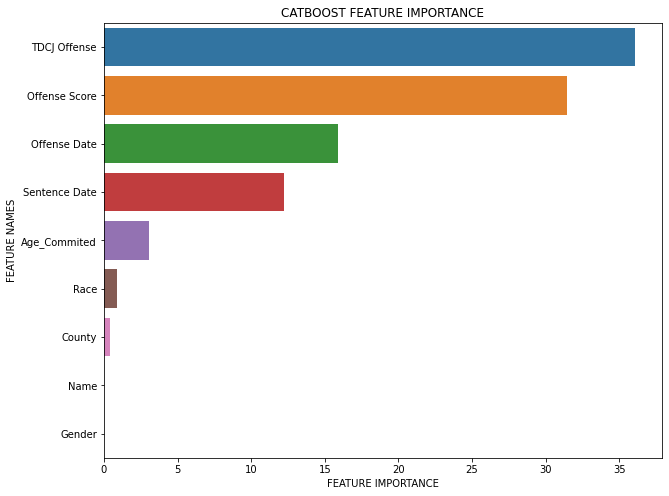

In [55]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

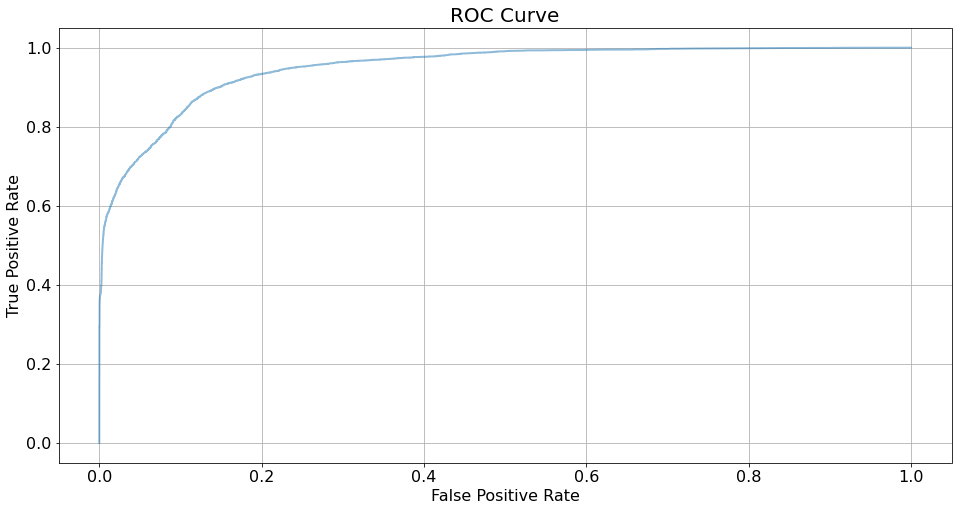

In [56]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [57]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[75688.   141.]
 [ 4047.  2511.]]


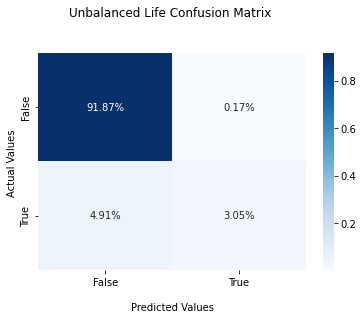

In [58]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Unbalanced Life Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [59]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.5697912	test: 0.5695952	best: 0.5695952 (0)	total: 74.7ms	remaining: 3.66s
1:	learn: 0.4790748	test: 0.4787400	best: 0.4787400 (1)	total: 143ms	remaining: 3.43s
2:	learn: 0.4092123	test: 0.4078584	best: 0.4078584 (2)	total: 195ms	remaining: 3.05s
3:	learn: 0.3578682	test: 0.3571871	best: 0.3571871 (3)	total: 266ms	remaining: 3.05s
4:	learn: 0.3220170	test: 0.3217471	best: 0.3217471 (4)	total: 343ms	remaining: 3.09s
5:	learn: 0.2891244	test: 0.2890102	best: 0.2890102 (5)	total: 390ms	remaining: 2.86s
6:	learn: 0.2685963	test: 0.2685502	best: 0.2685502 (6)	total: 435ms	remaining: 2.67s
7:	learn: 0.2500319	test: 0.2500027	best: 0.2500027 (7)	total: 481ms	remaining: 2.52s
8:	learn: 0.2345887	test: 0.2347779	best: 0.2347779 (8)	total: 530ms	remaining: 2.41s
9:	learn: 0.2219711	test: 0.2215773	best: 0.2215773 (9)	total: 598ms	remaining: 2.39s
10:	learn: 0.2097522	test: 0.2084237	best: 0.2084237 (10)	total: 681ms	remaining: 2.41s
11:	learn: 0.2032047	test: 

### Predicting Greater than 50 Years

In [60]:
df_model_50=df_clean.drop(columns = ['Projected Release', 'Maximum Sentence Date', 'Parole Eligibility Date', 'Last Parole Decision', 'Next Parole Review Date', 'TDCJ_Offense', 'Current Facility', 'Age', 'Year_Commited', 'Parole_Decision', 'Parole Review Status'])
df_model_50.head()

,Name,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Age_Commited
SID Number,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,300,67.0
703267,"RODRIGUEZ,THEODORE",M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,200,58.0
770626,"FLORES,ISABEL",M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,200,49.0
771601,"MOLETT,JOHN HENRY",M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,150,65.0
779423,"CARAWAY,LEON JR",M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,300,62.0


In [61]:
def fifty(x):
  if x >= 50:
      return 1
  else:
     return 0

df_model_50["Sentence (Years)"] = df_model_50["Sentence (Years)"].map(lambda x: fifty(x), na_action='ignore')
df_model_50["Offense Date"] = df_model_50["Offense Date"].astype(str)
df_model_50["Sentence Date"] = df_model_50["Sentence Date"].astype(str)
df_model_50 = df_model_50.dropna()
df_model_50.head()


,Name,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Age_Commited
SID Number,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,1,300,67.0
703267,"RODRIGUEZ,THEODORE",M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,0,200,58.0
770626,"FLORES,ISABEL",M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,1,200,49.0
771601,"MOLETT,JOHN HENRY",M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,0,150,65.0
779423,"CARAWAY,LEON JR",M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,0,300,62.0


In [62]:
df_model_50['Sentence (Years)'].value_counts()

0    99643
1    18053
Name: Sentence (Years), dtype: int64

#### Balanced

In [63]:
df_balance_model = df_model_50[df_model_50['Sentence (Years)'] == 0]
df_balance_model = df_balance_model.sample(n=18053)
df_balance_model.shape[0]

18053

In [64]:
train_miss = df_model_50[df_model_50['Sentence (Years)'] == 1]
df_balance_model = pd.concat([df_balance_model, train_miss])
df_balance_model['Sentence (Years)'].value_counts()

1    18053
0    18053
Name: Sentence (Years), dtype: int64

In [65]:
# With BALANCING
X = df_balance_model.drop(columns = ['Sentence (Years)'])
y = df_balance_model['Sentence (Years)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_balance_model.select_dtypes(include=np.object).columns.to_list()

In [66]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6683528	test: 0.6686061	best: 0.6686061 (0)	total: 15.3ms	remaining: 752ms
1:	learn: 0.6415980	test: 0.6394162	best: 0.6394162 (1)	total: 29.5ms	remaining: 709ms
2:	learn: 0.6195886	test: 0.6150546	best: 0.6150546 (2)	total: 38ms	remaining: 595ms
3:	learn: 0.6010309	test: 0.5946440	best: 0.5946440 (3)	total: 47.3ms	remaining: 543ms
4:	learn: 0.5819135	test: 0.5736335	best: 0.5736335 (4)	total: 63.4ms	remaining: 571ms
5:	learn: 0.5659767	test: 0.5558646	best: 0.5558646 (5)	total: 73.4ms	remaining: 538ms
6:	learn: 0.5527173	test: 0.5414345	best: 0.5414345 (6)	total: 84ms	remaining: 516ms
7:	learn: 0.5411306	test: 0.5282909	best: 0.5282909 (7)	total: 105ms	remaining: 553ms
8:	learn: 0.5308788	test: 0.5166472	best: 0.5166472 (8)	total: 120ms	remaining: 548ms
9:	learn: 0.5223654	test: 0.5070601	best: 0.5070601 (9)	total: 129ms	remaining: 517ms
10:	learn: 0.5154820	test: 0.4989359	best: 0.4989359 (10)	total: 138ms	remaining: 491ms
11:	learn: 0.5091157	test: 0.4920821	best: 0.4920

In [67]:
model.score(X_test, y_test)

0.809361152141802

In [68]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["Under 50", "Over 50"]))

              precision    recall  f1-score   support

    Under 50       0.81      0.81      0.81      5385
     Over 50       0.81      0.81      0.81      5447

    accuracy                           0.81     10832
   macro avg       0.81      0.81      0.81     10832
weighted avg       0.81      0.81      0.81     10832



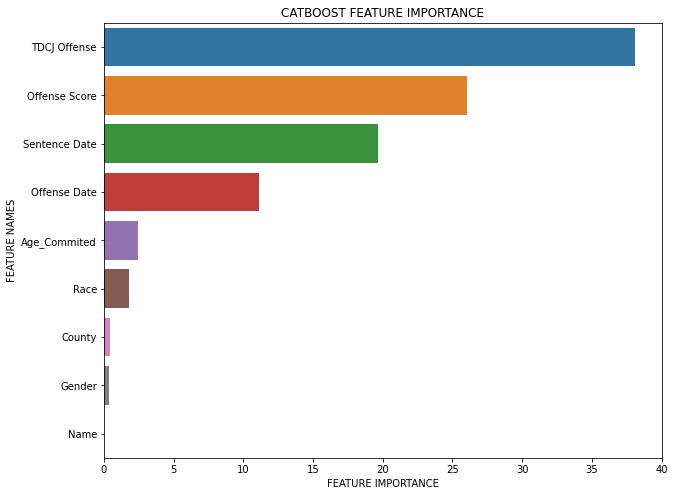

In [69]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

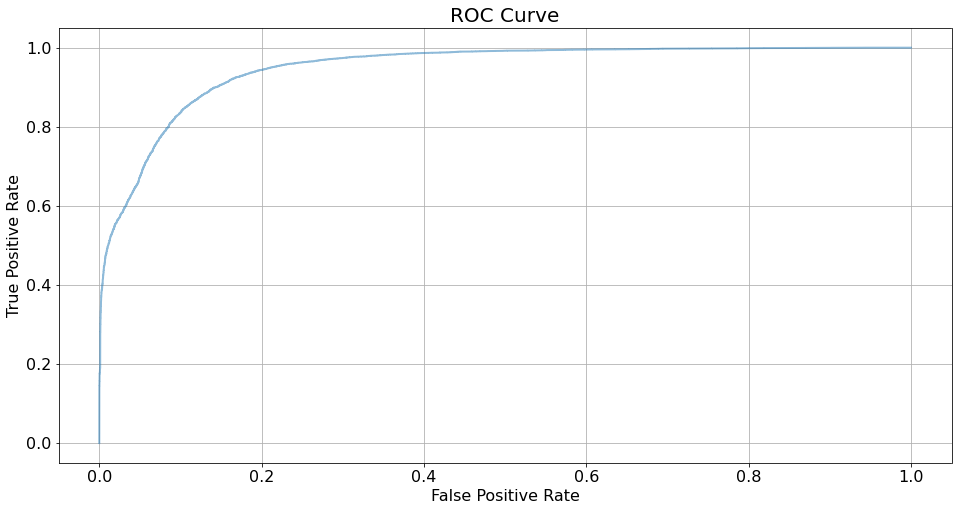

In [70]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [71]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[11157.  1511.]
 [ 1659. 10947.]]


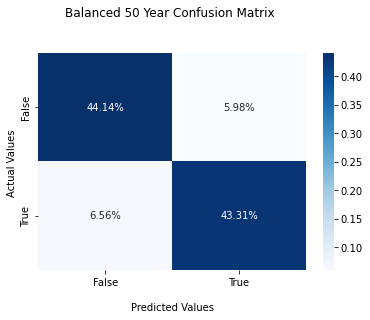

In [72]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Balanced 50 Year Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [73]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6640163	test: 0.6637199	best: 0.6637199 (0)	total: 21.4ms	remaining: 1.05s
1:	learn: 0.6318223	test: 0.6281773	best: 0.6281773 (1)	total: 46.7ms	remaining: 1.12s
2:	learn: 0.6055535	test: 0.5997852	best: 0.5997852 (2)	total: 70.7ms	remaining: 1.11s
3:	learn: 0.5790437	test: 0.5687363	best: 0.5687363 (3)	total: 99ms	remaining: 1.14s
4:	learn: 0.5584953	test: 0.5464581	best: 0.5464581 (4)	total: 117ms	remaining: 1.05s
5:	learn: 0.5442110	test: 0.5304032	best: 0.5304032 (5)	total: 150ms	remaining: 1.1s
6:	learn: 0.5309027	test: 0.5158617	best: 0.5158617 (6)	total: 165ms	remaining: 1.01s
7:	learn: 0.5163349	test: 0.4994086	best: 0.4994086 (7)	total: 184ms	remaining: 965ms
8:	learn: 0.5077838	test: 0.4899937	best: 0.4899937 (8)	total: 199ms	remaining: 907ms
9:	learn: 0.5005215	test: 0.4812360	best: 0.4812360 (9)	total: 214ms	remaining: 856ms
10:	learn: 0.4953211	test: 0.4755543	best: 0.4755543 (10)	total: 229ms	remaining: 813ms
11:	learn: 0.4891869	test: 

#### No Balancing

In [74]:
# Without BALANCING
X = df_model_50.drop(columns = ['Sentence (Years)'])
y = df_model_50['Sentence (Years)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_model_50.select_dtypes(include=np.object).columns.to_list()
X.info()
df_model_50['Sentence (Years)'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117696 entries, 524524 to 96414913
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           117696 non-null  object 
 1   Gender         117696 non-null  object 
 2   Race           117696 non-null  object 
 3   County         117696 non-null  object 
 4   TDCJ Offense   117696 non-null  object 
 5   Sentence Date  117696 non-null  object 
 6   Offense Date   117696 non-null  object 
 7   Offense Score  117696 non-null  int64  
 8   Age_Commited   117696 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 9.0+ MB


0    99643
1    18053
Name: Sentence (Years), dtype: int64

In [75]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6394871	test: 0.6393775	best: 0.6393775 (0)	total: 49.5ms	remaining: 2.43s
1:	learn: 0.5947749	test: 0.5947376	best: 0.5947376 (1)	total: 75.6ms	remaining: 1.81s
2:	learn: 0.5577192	test: 0.5577650	best: 0.5577650 (2)	total: 113ms	remaining: 1.77s
3:	learn: 0.5233863	test: 0.5217187	best: 0.5217187 (3)	total: 147ms	remaining: 1.7s
4:	learn: 0.4946422	test: 0.4920687	best: 0.4920687 (4)	total: 175ms	remaining: 1.57s
5:	learn: 0.4701637	test: 0.4661773	best: 0.4661773 (5)	total: 204ms	remaining: 1.5s
6:	learn: 0.4465577	test: 0.4407537	best: 0.4407537 (6)	total: 241ms	remaining: 1.48s
7:	learn: 0.4254174	test: 0.4190841	best: 0.4190841 (7)	total: 272ms	remaining: 1.43s
8:	learn: 0.4077020	test: 0.4009387	best: 0.4009387 (8)	total: 299ms	remaining: 1.36s
9:	learn: 0.3921208	test: 0.3846179	best: 0.3846179 (9)	total: 325ms	remaining: 1.3s
10:	learn: 0.3785669	test: 0.3707670	best: 0.3707670 (10)	total: 352ms	remaining: 1.25s
11:	learn: 0.3675977	test: 0.3591532	best: 0.3591532 

In [76]:
model.score(X_test, y_test)

0.8846186524682093

In [77]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["Under 50", "Over 50"]))

              precision    recall  f1-score   support

    Under 50       0.89      0.98      0.93     29822
     Over 50       0.76      0.37      0.50      5487

    accuracy                           0.88     35309
   macro avg       0.83      0.68      0.72     35309
weighted avg       0.87      0.88      0.87     35309



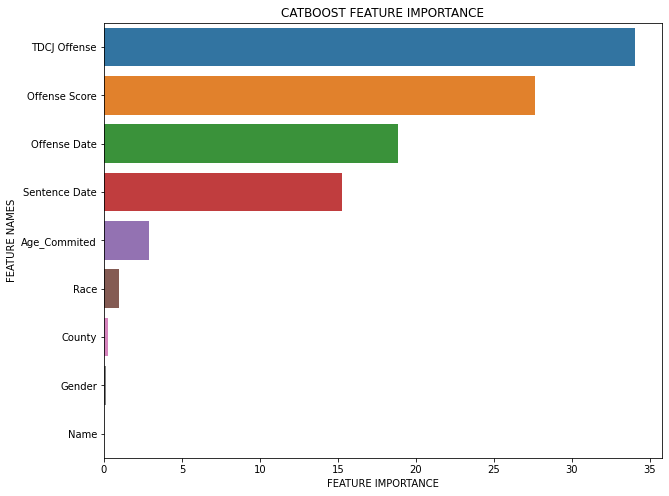

In [78]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

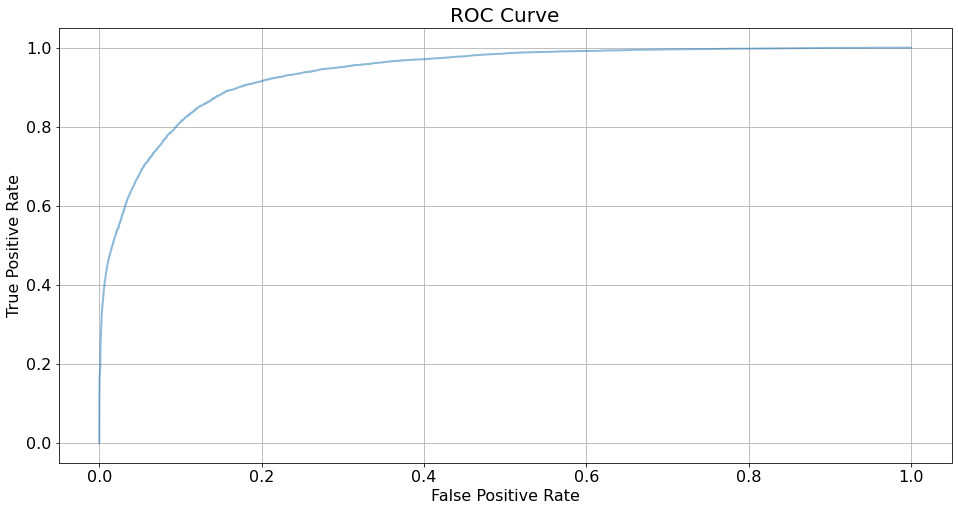

In [79]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [80]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[69016.   805.]
 [ 6723.  5843.]]


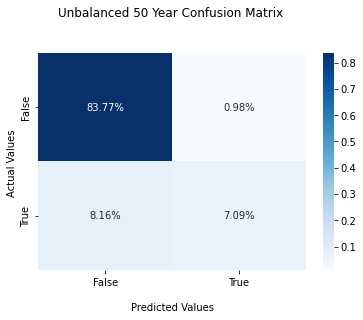

In [81]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Unbalanced 50 Year Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [82]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6137560	test: 0.6137817	best: 0.6137817 (0)	total: 119ms	remaining: 5.85s
1:	learn: 0.5530062	test: 0.5535979	best: 0.5535979 (1)	total: 190ms	remaining: 4.57s
2:	learn: 0.5059193	test: 0.5068131	best: 0.5068131 (2)	total: 245ms	remaining: 3.85s
3:	learn: 0.4605377	test: 0.4599819	best: 0.4599819 (3)	total: 293ms	remaining: 3.37s
4:	learn: 0.4264032	test: 0.4250617	best: 0.4250617 (4)	total: 347ms	remaining: 3.13s
5:	learn: 0.3954828	test: 0.3928124	best: 0.3928124 (5)	total: 399ms	remaining: 2.93s
6:	learn: 0.3738859	test: 0.3699301	best: 0.3699301 (6)	total: 462ms	remaining: 2.84s
7:	learn: 0.3549411	test: 0.3518175	best: 0.3518175 (7)	total: 509ms	remaining: 2.67s
8:	learn: 0.3416356	test: 0.3392599	best: 0.3392599 (8)	total: 574ms	remaining: 2.62s
9:	learn: 0.3287982	test: 0.3256197	best: 0.3256197 (9)	total: 624ms	remaining: 2.49s
10:	learn: 0.3189472	test: 0.3175597	best: 0.3175597 (10)	total: 699ms	remaining: 2.48s
11:	learn: 0.3110638	test: 0

### Predicting Greater than 20 years

In [83]:
df_model_20=df_clean.drop(columns = ['Projected Release', 'Maximum Sentence Date', 'Parole Eligibility Date', 'Last Parole Decision', 'Next Parole Review Date', 'TDCJ_Offense', 'Current Facility', 'Age', 'Year_Commited', 'Parole_Decision', 'Parole Review Status'])
df_model_20.head()

,Name,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Age_Commited
SID Number,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,300,67.0
703267,"RODRIGUEZ,THEODORE",M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,200,58.0
770626,"FLORES,ISABEL",M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,200,49.0
771601,"MOLETT,JOHN HENRY",M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,150,65.0
779423,"CARAWAY,LEON JR",M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,300,62.0


In [84]:
def twenty(x):
  if x >= 20:
      return 1
  else:
     return 0

df_model_20["Sentence (Years)"] = df_model_20["Sentence (Years)"].map(lambda x: twenty(x), na_action='ignore')
df_model_20["Offense Date"] = df_model_20["Offense Date"].astype(str)
df_model_20["Sentence Date"] = df_model_20["Sentence Date"].astype(str)
df_model_20 = df_model_20.dropna()
df_model_20.head()


,Name,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Age_Commited
SID Number,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,1,300,67.0
703267,"RODRIGUEZ,THEODORE",M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,1,200,58.0
770626,"FLORES,ISABEL",M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,1,200,49.0
771601,"MOLETT,JOHN HENRY",M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,1,150,65.0
779423,"CARAWAY,LEON JR",M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,1,300,62.0


In [85]:
df_model_20['Sentence (Years)'].value_counts()

0    69832
1    47864
Name: Sentence (Years), dtype: int64

In [86]:
X = df_model_20.drop(columns = ['Sentence (Years)'])
y = df_model_20['Sentence (Years)']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_model_20.select_dtypes(include=np.object).columns.to_list()
X.info()
df_model_20['Sentence (Years)'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117696 entries, 524524 to 96414913
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Name           117696 non-null  object 
 1   Gender         117696 non-null  object 
 2   Race           117696 non-null  object 
 3   County         117696 non-null  object 
 4   TDCJ Offense   117696 non-null  object 
 5   Sentence Date  117696 non-null  object 
 6   Offense Date   117696 non-null  object 
 7   Offense Score  117696 non-null  int64  
 8   Age_Commited   117696 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 9.0+ MB


0    69832
1    47864
Name: Sentence (Years), dtype: int64

In [87]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6540014	test: 0.6507713	best: 0.6507713 (0)	total: 45.1ms	remaining: 2.21s
1:	learn: 0.6215809	test: 0.6170346	best: 0.6170346 (1)	total: 72.5ms	remaining: 1.74s
2:	learn: 0.5943873	test: 0.5874234	best: 0.5874234 (2)	total: 110ms	remaining: 1.72s
3:	learn: 0.5714731	test: 0.5630960	best: 0.5630960 (3)	total: 147ms	remaining: 1.69s
4:	learn: 0.5500230	test: 0.5416116	best: 0.5416116 (4)	total: 185ms	remaining: 1.67s
5:	learn: 0.5317705	test: 0.5242400	best: 0.5242400 (5)	total: 216ms	remaining: 1.58s
6:	learn: 0.5143370	test: 0.5069436	best: 0.5069436 (6)	total: 246ms	remaining: 1.51s
7:	learn: 0.4999905	test: 0.4923258	best: 0.4923258 (7)	total: 276ms	remaining: 1.45s
8:	learn: 0.4875506	test: 0.4800879	best: 0.4800879 (8)	total: 303ms	remaining: 1.38s
9:	learn: 0.4766829	test: 0.4681713	best: 0.4681713 (9)	total: 329ms	remaining: 1.32s
10:	learn: 0.4673298	test: 0.4589469	best: 0.4589469 (10)	total: 356ms	remaining: 1.26s
11:	learn: 0.4593308	test: 0.4502356	best: 0.45023

In [88]:
model.score(X_test, y_test)

0.8398708544563709

In [89]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["Under 20", "Over 20"]))

              precision    recall  f1-score   support

    Under 20       0.84      0.90      0.87     20983
     Over 20       0.84      0.75      0.79     14326

    accuracy                           0.84     35309
   macro avg       0.84      0.82      0.83     35309
weighted avg       0.84      0.84      0.84     35309



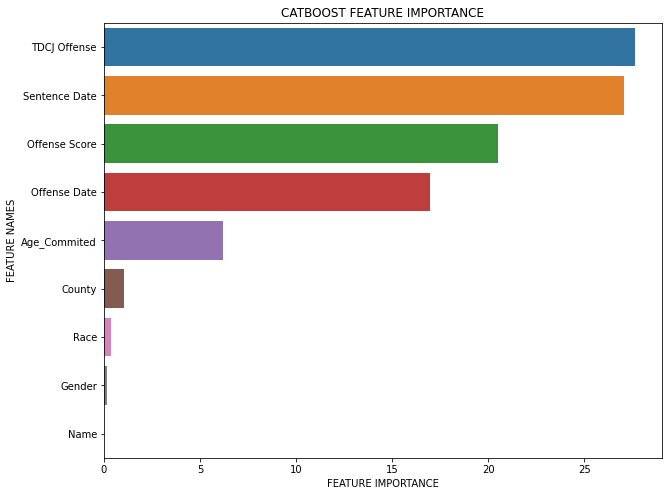

In [90]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

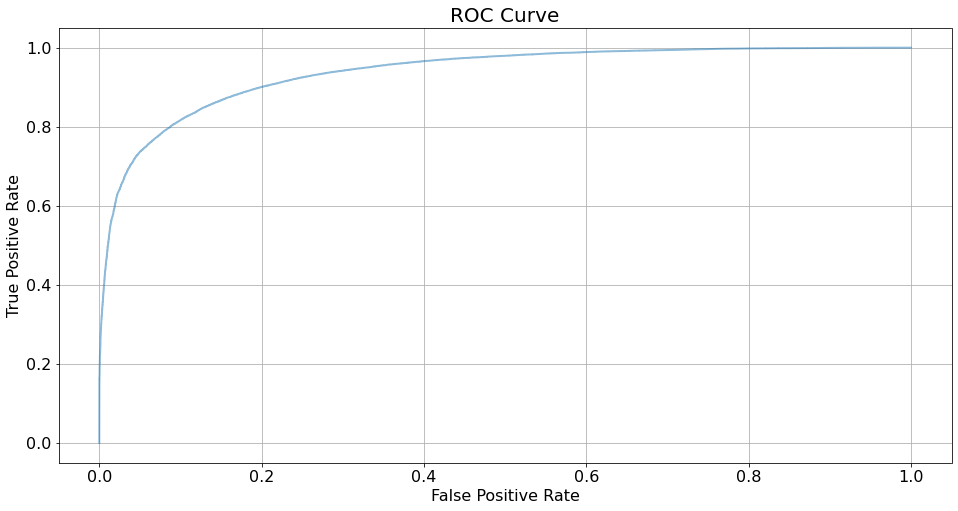

In [91]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [92]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[45351.  3498.]
 [ 7549. 25989.]]


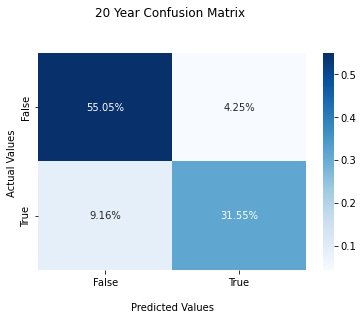

In [93]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('20 Year Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [94]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6426901	test: 0.6409062	best: 0.6409062 (0)	total: 71.5ms	remaining: 3.5s
1:	learn: 0.6014619	test: 0.5963633	best: 0.5963633 (1)	total: 121ms	remaining: 2.9s
2:	learn: 0.5690896	test: 0.5618964	best: 0.5618964 (2)	total: 179ms	remaining: 2.81s
3:	learn: 0.5406912	test: 0.5337627	best: 0.5337627 (3)	total: 226ms	remaining: 2.6s
4:	learn: 0.5180135	test: 0.5123085	best: 0.5123085 (4)	total: 285ms	remaining: 2.57s
5:	learn: 0.4969350	test: 0.4905786	best: 0.4905786 (5)	total: 353ms	remaining: 2.59s
6:	learn: 0.4811350	test: 0.4743047	best: 0.4743047 (6)	total: 396ms	remaining: 2.43s
7:	learn: 0.4677575	test: 0.4595622	best: 0.4595622 (7)	total: 440ms	remaining: 2.31s
8:	learn: 0.4571820	test: 0.4484296	best: 0.4484296 (8)	total: 487ms	remaining: 2.22s
9:	learn: 0.4469184	test: 0.4378439	best: 0.4378439 (9)	total: 534ms	remaining: 2.13s
10:	learn: 0.4403583	test: 0.4311096	best: 0.4311096 (10)	total: 594ms	remaining: 2.1s
11:	learn: 0.4332220	test: 0.42

### Predicting Approved for Parole

In [95]:
df_model_parole=df_clean.drop(columns = ['Projected Release', 'Maximum Sentence Date', 'Parole Eligibility Date', 'Last Parole Decision', 'Next Parole Review Date', 'TDCJ_Offense', 'Age', 'Year_Commited', 'Parole Review Status'])
df_model_parole.head()

,Name,Current Facility,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Parole_Decision,Age_Commited
SID Number,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,300,0.0,67.0
703267,"RODRIGUEZ,THEODORE",Beto,M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,200,1.0,58.0
770626,"FLORES,ISABEL",Pack,M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,200,0.0,49.0
771601,"MOLETT,JOHN HENRY",Pack,M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,150,0.0,65.0
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,300,0.0,62.0


In [96]:
df_model_parole["Offense Date"] = df_model_parole["Offense Date"].astype(str)
df_model_parole["Sentence Date"] = df_model_parole["Sentence Date"].astype(str)
#df_model_parole["Projected Release"] = df_model_parole["Projected Release"].astype(str)
#df_model_parole["Maximum Sentence Date"] = df_model_parole["Maximum Sentence Date"].astype(str)
df_model_parole = df_model_parole.dropna()
df_model_parole.head()

,Name,Current Facility,Gender,Race,County,TDCJ Offense,Sentence Date,Offense Date,Sentence (Years),Offense Score,Parole_Decision,Age_Commited
SID Number,,,,,,,,,,,,
524524,"HARPER,DAVID JOHN JR",Estelle,M,W,McLennan,AGG SEXUAL ASSAULT,1996-08-13 00:00:00,1995-09-15 00:00:00,100.0,300,0.0,67.0
703267,"RODRIGUEZ,THEODORE",Beto,M,W,McLennan,AGG SEX ASLT,1998-08-05 00:00:00,1996-06-01 00:00:00,45.0,200,1.0,58.0
770626,"FLORES,ISABEL",Pack,M,H,Nueces,MURDER W/DEADLY WPN,1987-04-13 00:00:00,1986-09-02 00:00:00,100.0,200,0.0,49.0
771601,"MOLETT,JOHN HENRY",Pack,M,B,Harris,AGG ROBBERY W/DW,2008-02-21 00:00:00,2007-12-03 00:00:00,30.0,150,0.0,65.0
779423,"CARAWAY,LEON JR",C.T. Terrell,M,B,Shelby,AGG SEXUAL ALST,2004-05-13 00:00:00,1999-07-24 00:00:00,20.0,300,0.0,62.0


In [97]:
df_model_parole["Parole_Decision"].value_counts()

0.0    96323
1.0    12266
Name: Parole_Decision, dtype: int64

#### Balanced

In [98]:
df_balance_model = df_model_parole[df_model_parole['Parole_Decision'] == 0]
df_balance_model = df_balance_model.sample(n=12266)
df_balance_model.shape[0]

12266

In [99]:
train_miss = df_model_parole[df_model_parole['Parole_Decision'] == 1]
df_balance_model = pd.concat([df_balance_model, train_miss])
df_balance_model['Sentence (Years)'].value_counts()

5.0     2439
10.0    2309
3.0     1600
15.0    1573
4.0     1537
        ... 
13.5       1
62.0       1
6.7        1
63.0       1
3.3        1
Name: Sentence (Years), Length: 113, dtype: int64

In [100]:
X = df_balance_model.drop(columns = ['Parole_Decision'])
y = df_balance_model['Parole_Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_balance_model.select_dtypes(include=np.object).columns.to_list()

In [101]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6663142	test: 0.6665910	best: 0.6665910 (0)	total: 33.4ms	remaining: 1.64s
1:	learn: 0.6439669	test: 0.6444984	best: 0.6444984 (1)	total: 44.5ms	remaining: 1.07s
2:	learn: 0.6248815	test: 0.6256818	best: 0.6256818 (2)	total: 51.4ms	remaining: 805ms
3:	learn: 0.6082969	test: 0.6097661	best: 0.6097661 (3)	total: 60.7ms	remaining: 698ms
4:	learn: 0.5939577	test: 0.5961193	best: 0.5961193 (4)	total: 67.7ms	remaining: 609ms
5:	learn: 0.5817577	test: 0.5841964	best: 0.5841964 (5)	total: 74.4ms	remaining: 546ms
6:	learn: 0.5714109	test: 0.5743378	best: 0.5743378 (6)	total: 81.4ms	remaining: 500ms
7:	learn: 0.5628321	test: 0.5658790	best: 0.5658790 (7)	total: 88.3ms	remaining: 464ms
8:	learn: 0.5552881	test: 0.5587225	best: 0.5587225 (8)	total: 100ms	remaining: 457ms
9:	learn: 0.5484349	test: 0.5521247	best: 0.5521247 (9)	total: 108ms	remaining: 430ms
10:	learn: 0.5424597	test: 0.5461206	best: 0.5461206 (10)	total: 117ms	remaining: 415ms
11:	learn: 0.5382072	test: 0.5421169	best: 0

In [102]:
model.score(X_test, y_test)

0.7464673913043478

In [103]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["No Parole", "Approved Parole"]))

                 precision    recall  f1-score   support

      No Parole       0.72      0.80      0.76      3653
Approved Parole       0.78      0.69      0.73      3707

       accuracy                           0.75      7360
      macro avg       0.75      0.75      0.75      7360
   weighted avg       0.75      0.75      0.75      7360



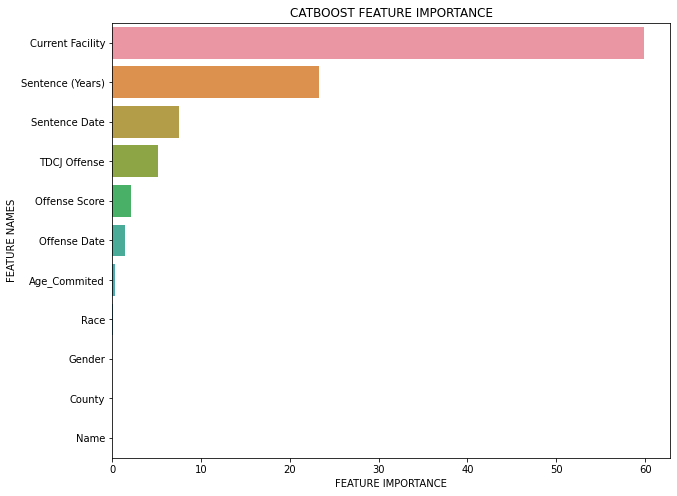

In [104]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

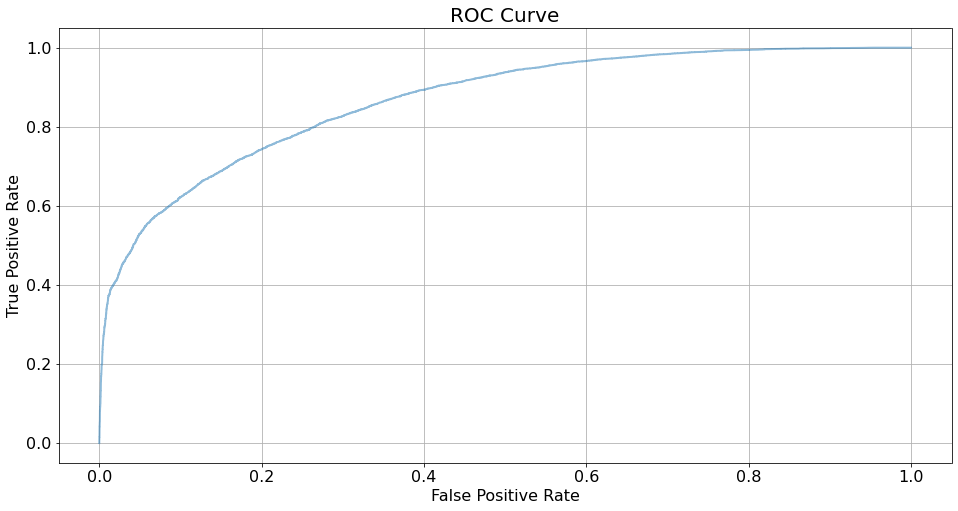

In [105]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [106]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[7246. 1367.]
 [2579. 5980.]]


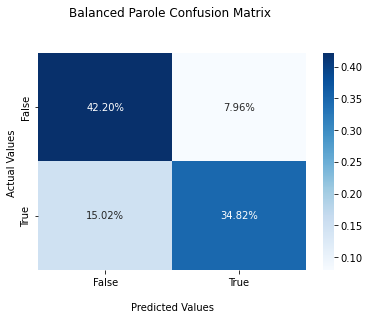

In [107]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Balanced Parole Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [108]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.6591834	test: 0.6580762	best: 0.6580762 (0)	total: 34.7ms	remaining: 1.7s
1:	learn: 0.6306413	test: 0.6285103	best: 0.6285103 (1)	total: 49.1ms	remaining: 1.18s
2:	learn: 0.6092126	test: 0.6052552	best: 0.6052552 (2)	total: 68.6ms	remaining: 1.07s
3:	learn: 0.5895580	test: 0.5837970	best: 0.5837970 (3)	total: 81.2ms	remaining: 933ms
4:	learn: 0.5749202	test: 0.5681886	best: 0.5681886 (4)	total: 97ms	remaining: 873ms
5:	learn: 0.5625162	test: 0.5559305	best: 0.5559305 (5)	total: 124ms	remaining: 911ms
6:	learn: 0.5532127	test: 0.5456215	best: 0.5456215 (6)	total: 140ms	remaining: 860ms
7:	learn: 0.5451128	test: 0.5377797	best: 0.5377797 (7)	total: 160ms	remaining: 840ms
8:	learn: 0.5391302	test: 0.5308774	best: 0.5308774 (8)	total: 174ms	remaining: 794ms
9:	learn: 0.5344955	test: 0.5253809	best: 0.5253809 (9)	total: 188ms	remaining: 753ms
10:	learn: 0.5278511	test: 0.5187568	best: 0.5187568 (10)	total: 208ms	remaining: 738ms
11:	learn: 0.5231744	test:

#### No Balancing

In [109]:
X = df_model_parole.drop(columns = ['Parole_Decision'])
y = df_model_parole['Parole_Decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1234)
categorical_features = df_model_parole.select_dtypes(include=np.object).columns.to_list()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108589 entries, 524524 to 50824569
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Name              108589 non-null  object 
 1   Current Facility  108589 non-null  object 
 2   Gender            108589 non-null  object 
 3   Race              108589 non-null  object 
 4   County            108589 non-null  object 
 5   TDCJ Offense      108589 non-null  object 
 6   Sentence Date     108589 non-null  object 
 7   Offense Date      108589 non-null  object 
 8   Sentence (Years)  108589 non-null  float64
 9   Offense Score     108589 non-null  int64  
 10  Age_Commited      108589 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 9.9+ MB


In [110]:
model=CatBoostClassifier(iterations=50, depth=3, learning_rate=0.1, loss_function='Logloss')
model.fit(X_train, y_train,cat_features=categorical_features,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6267629	test: 0.6262235	best: 0.6262235 (0)	total: 56.4ms	remaining: 2.76s
1:	learn: 0.5725718	test: 0.5714336	best: 0.5714336 (1)	total: 86.7ms	remaining: 2.08s
2:	learn: 0.5277753	test: 0.5261214	best: 0.5261214 (2)	total: 123ms	remaining: 1.93s
3:	learn: 0.4895531	test: 0.4873380	best: 0.4873380 (3)	total: 158ms	remaining: 1.82s
4:	learn: 0.4578265	test: 0.4551613	best: 0.4551613 (4)	total: 189ms	remaining: 1.7s
5:	learn: 0.4309458	test: 0.4278137	best: 0.4278137 (5)	total: 215ms	remaining: 1.57s
6:	learn: 0.4079945	test: 0.4044412	best: 0.4044412 (6)	total: 244ms	remaining: 1.5s
7:	learn: 0.3879585	test: 0.3842436	best: 0.3842436 (7)	total: 276ms	remaining: 1.45s
8:	learn: 0.3709864	test: 0.3669056	best: 0.3669056 (8)	total: 302ms	remaining: 1.38s
9:	learn: 0.3559394	test: 0.3515874	best: 0.3515874 (9)	total: 330ms	remaining: 1.32s
10:	learn: 0.3429087	test: 0.3383188	best: 0.3383188 (10)	total: 356ms	remaining: 1.26s
11:	learn: 0.3320157	test: 0.3269027	best: 0.3269027

In [111]:
model.score(X_test, y_test)

0.919483070878227

In [112]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred,target_names=["No Parole", "Approved Parole"]))

                 precision    recall  f1-score   support

      No Parole       0.92      0.99      0.96     28906
Approved Parole       0.83      0.36      0.50      3671

       accuracy                           0.92     32577
      macro avg       0.88      0.67      0.73     32577
   weighted avg       0.91      0.92      0.90     32577



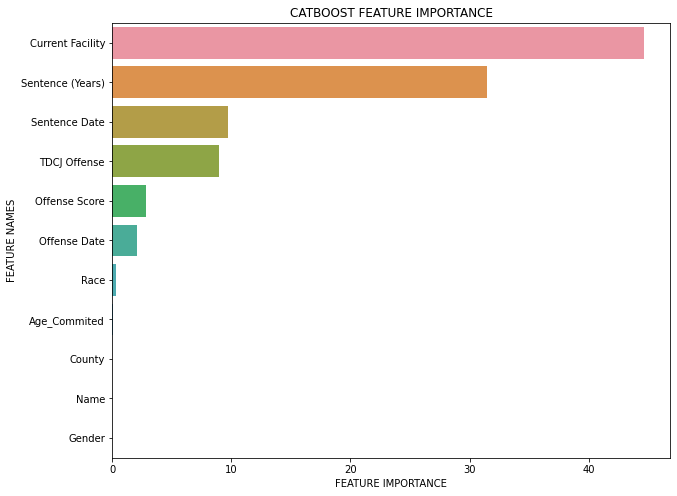

In [113]:
plot_feature_importance(model.get_feature_importance(Pool(X_train, y_train, cat_features=categorical_features)),X_train.columns,'CATBOOST')

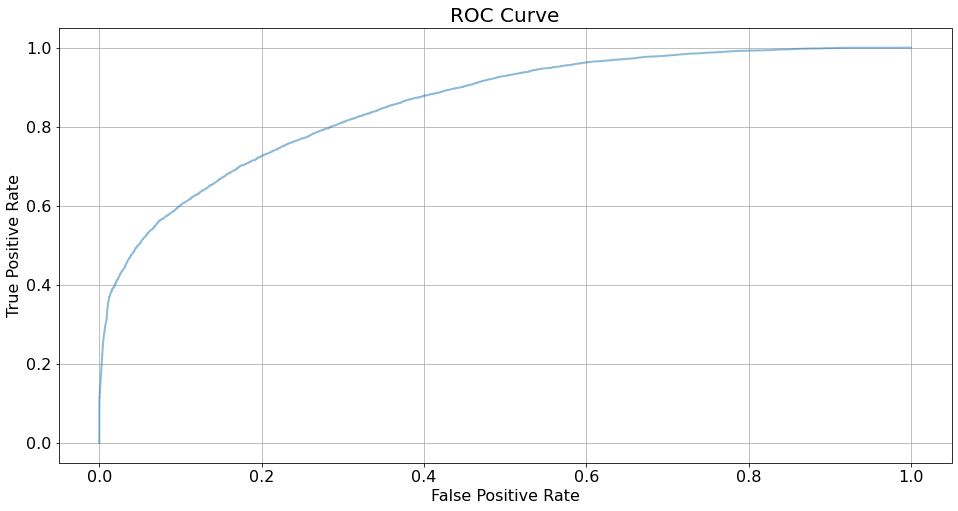

In [114]:
(fpr, tpr, thresholds) = get_roc_curve(model, Pool(X_train, y_train, cat_features=categorical_features), plot=True)

In [115]:
cm = get_confusion_matrix(model, Pool(X_train, y_train, cat_features=categorical_features))
print(cm)

[[66713.   704.]
 [ 5623.  2972.]]


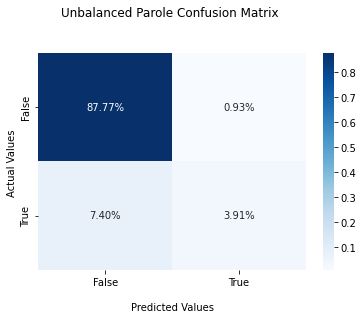

In [116]:
ax = sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, cmap='Blues')

ax.set_title('Unbalanced Parole Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

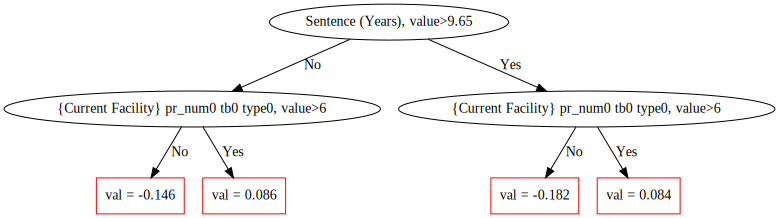

In [117]:
model.plot_tree(
    tree_idx=0,
    pool=Pool(X_train, y_train, cat_features=categorical_features)
)

In [118]:
params = {"iterations": 50,
          "depth": 3,
          "learning_rate": 0.1,
          "loss_function": "Logloss"}

scores = cv(Pool(X_train, y_train, cat_features=categorical_features), params, fold_count=10, plot="True")
print(scores)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 0.5977891	test: 0.5975790	best: 0.5975790 (0)	total: 75.3ms	remaining: 3.69s
1:	learn: 0.5220083	test: 0.5213027	best: 0.5213027 (1)	total: 119ms	remaining: 2.86s
2:	learn: 0.4617999	test: 0.4609644	best: 0.4609644 (2)	total: 174ms	remaining: 2.73s
3:	learn: 0.4153168	test: 0.4145224	best: 0.4145224 (3)	total: 221ms	remaining: 2.54s
4:	learn: 0.3821230	test: 0.3812707	best: 0.3812707 (4)	total: 281ms	remaining: 2.53s
5:	learn: 0.3575459	test: 0.3563850	best: 0.3563850 (5)	total: 340ms	remaining: 2.49s
6:	learn: 0.3382350	test: 0.3367940	best: 0.3367940 (6)	total: 384ms	remaining: 2.36s
7:	learn: 0.3217931	test: 0.3203204	best: 0.3203204 (7)	total: 426ms	remaining: 2.24s
8:	learn: 0.3088943	test: 0.3071165	best: 0.3071165 (8)	total: 473ms	remaining: 2.15s
9:	learn: 0.2994952	test: 0.2976399	best: 0.2976399 (9)	total: 518ms	remaining: 2.07s
10:	learn: 0.2911897	test: 0.2892187	best: 0.2892187 (10)	total: 567ms	remaining: 2.01s
11:	learn: 0.2851165	test: 